In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gold-prices/annual_csv.csv
/kaggle/input/gold-prices/monthly_csv.csv


> > ****Import libraries & data**

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Import model libraries
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# Suppress the warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import the price data
df = pd.read_csv("../input/gold-prices/monthly_csv.csv")
df.head()

,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [4]:
df.shape

(847, 2)

**Exploratory Data Analysis**

**Understanding the data******

In [5]:
print(f"Date range of gold prices available from - {df.loc[:,'Date'][0]} to {df.loc[:,'Date'][len(df)-1]}")

Date range of gold prices available from - 1950-01 to 2020-07


In [6]:
date = pd.date_range(start='1/1/1950', end='8/1/2020', freq='M')
date

DatetimeIndex(['1950-01-31', '1950-02-28', '1950-03-31', '1950-04-30',
               '1950-05-31', '1950-06-30', '1950-07-31', '1950-08-31',
               '1950-09-30', '1950-10-31',
               ...
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31'],
              dtype='datetime64[ns]', length=847, freq='M')

In [7]:
df['month'] = date
df.drop('Date',axis=1,inplace=True)
df = df.set_index('month')
df.head()

,Price
month,
1950-01-31,34.73
1950-02-28,34.73
1950-03-31,34.73
1950-04-30,34.73
1950-05-31,34.73


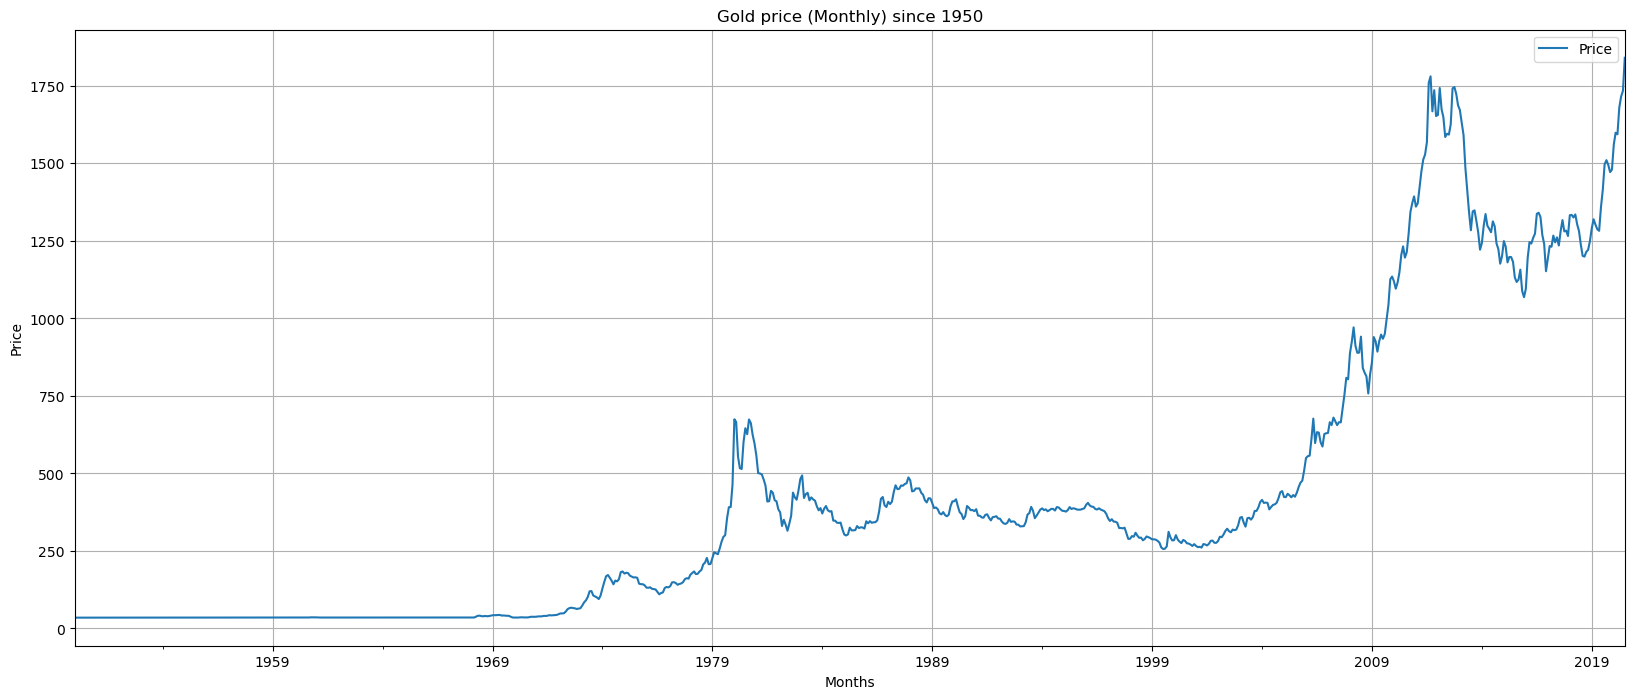

In [8]:
df.plot(figsize=(20,8))
plt.title("Gold price (Monthly) since 1950")
plt.xlabel("Months")
plt.ylabel("Price")
plt.grid();

In [9]:
round(df.describe(),3)

,Price
count,847.000
mean,416.557
std,453.665
min,34.490
25%,35.190
50%,319.622
75%,447.029
max,1840.807


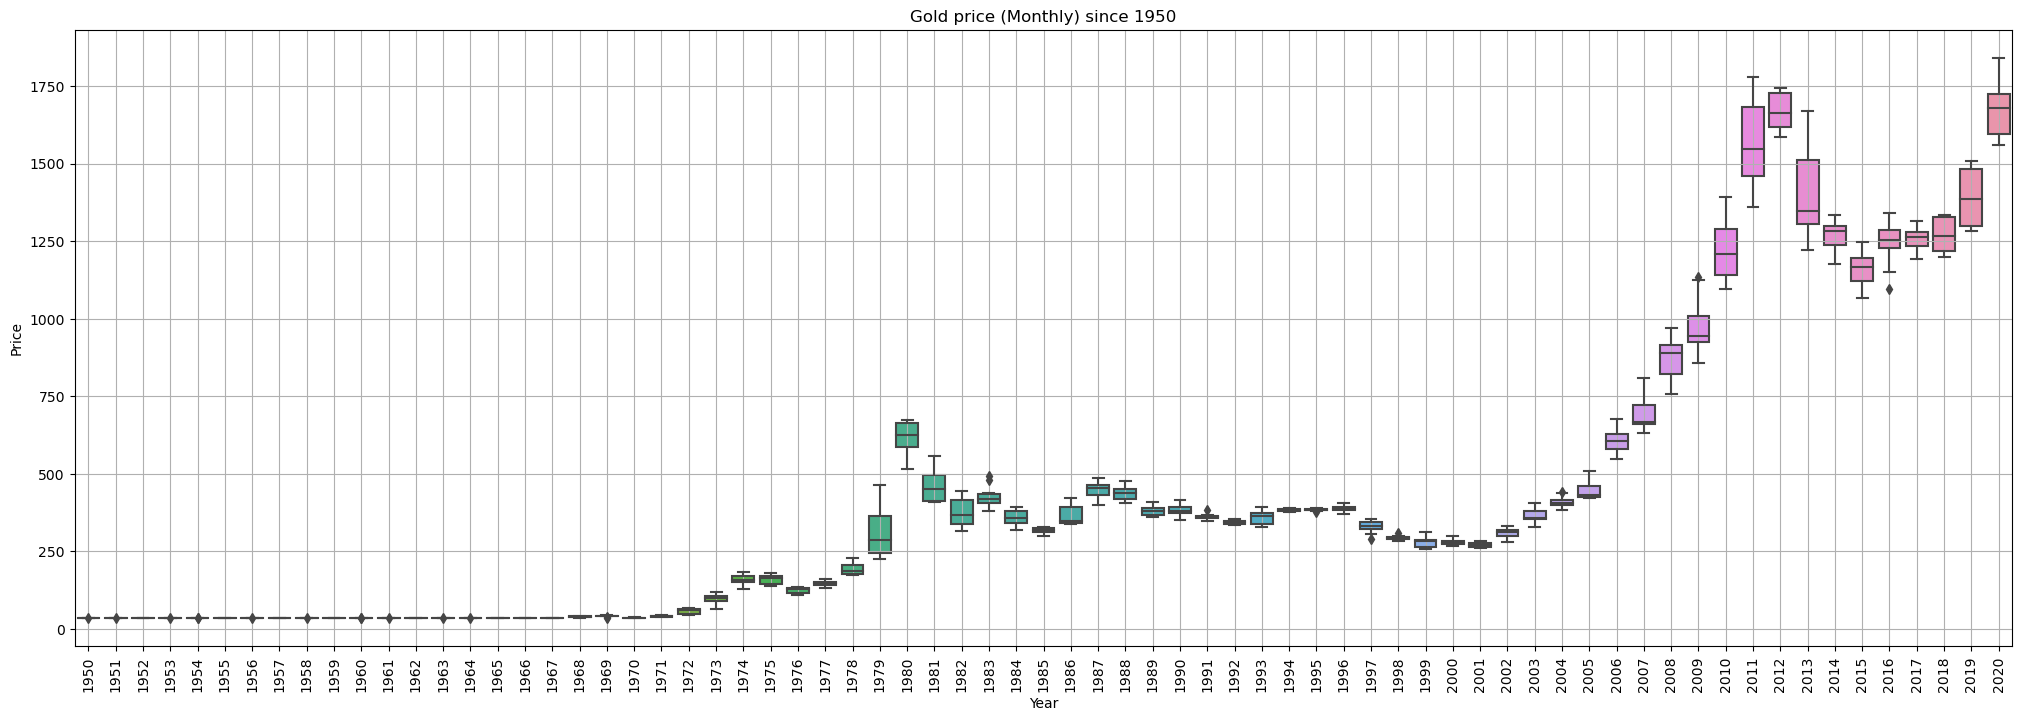

In [10]:
_, ax = plt.subplots(figsize=(25,8))
sns.boxplot(x = df.index.year,y = df.values[:,0],ax=ax)
plt.title("Gold price (Monthly) since 1950")
plt.xlabel("Year")
plt.ylabel("Price")
plt.xticks(rotation=90)
plt.grid();

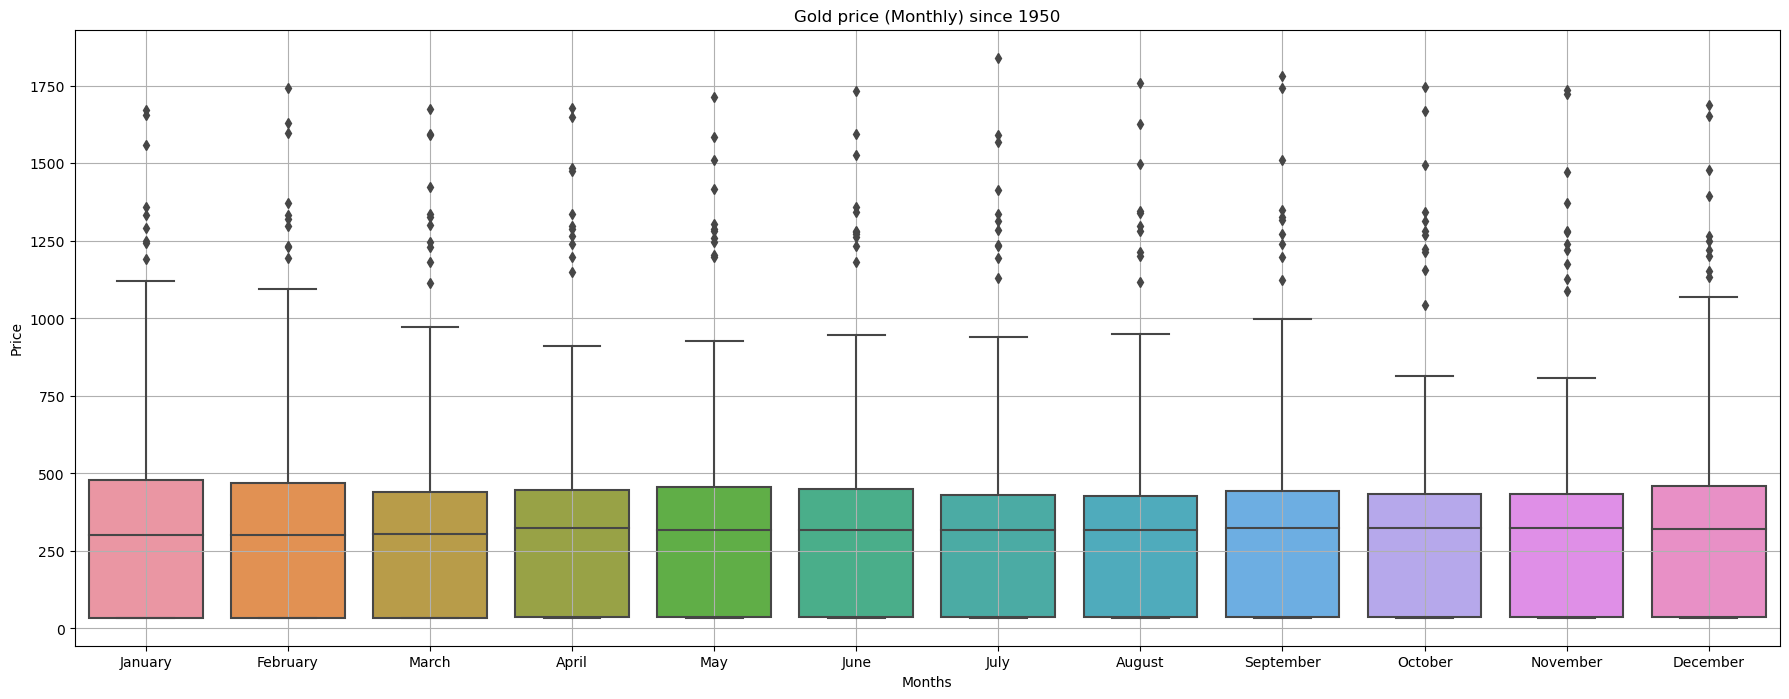

In [11]:
_, ax = plt.subplots(figsize=(22,8))
sns.boxplot(x = df.index.month_name(),y = df.values[:,0],ax=ax)
plt.title("Gold price (Monthly) since 1950")
plt.xlabel("Months")
plt.ylabel("Price")
plt.grid();

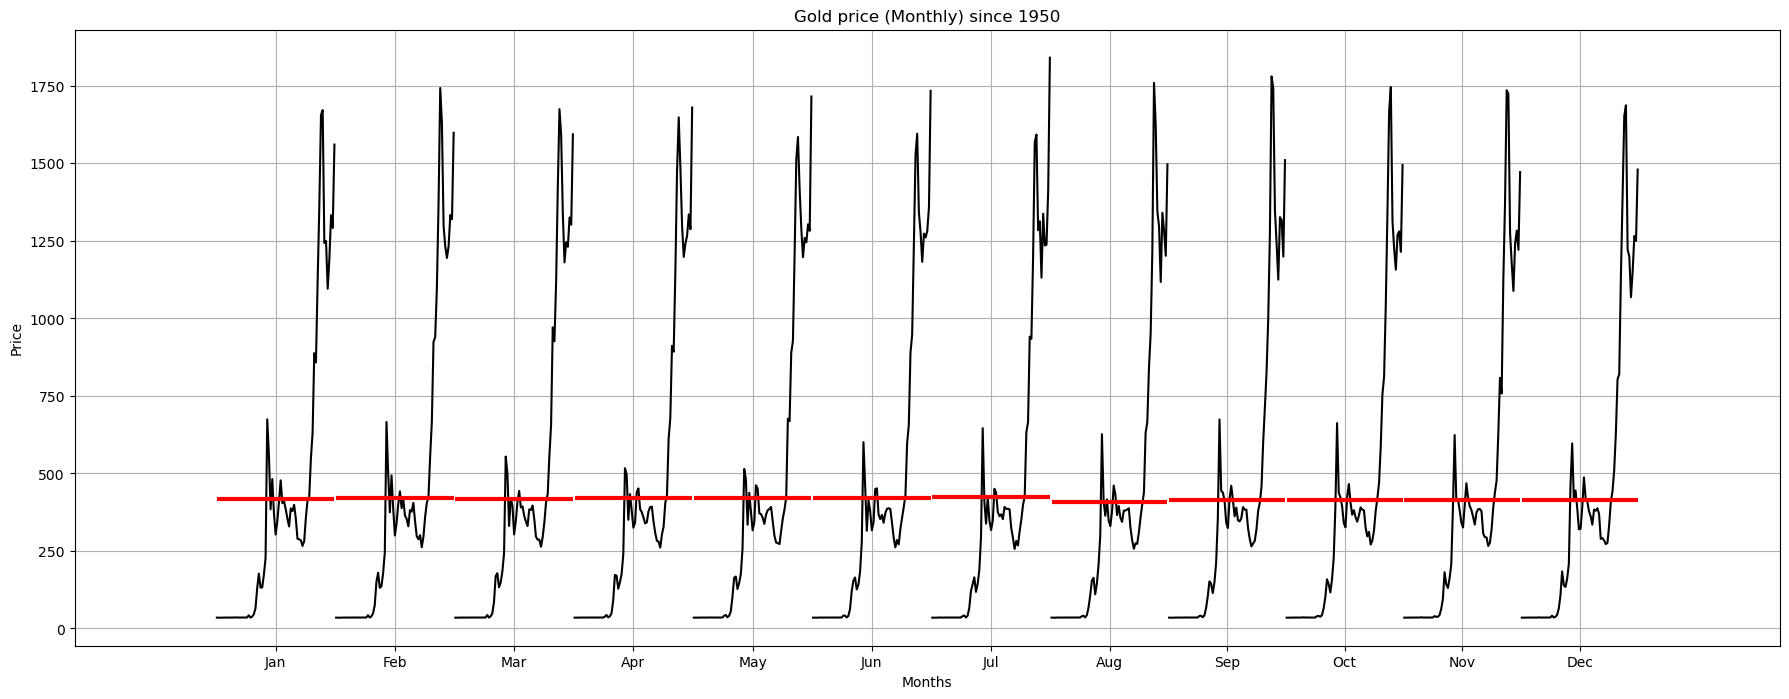

In [12]:
from statsmodels.graphics.tsaplots import month_plot

fig, ax = plt.subplots(figsize=(22,8))

month_plot(df,ylabel='Gold price',ax=ax)
plt.title("Gold price (Monthly) since 1950")
plt.xlabel("Months")
plt.ylabel("Price")
plt.grid();

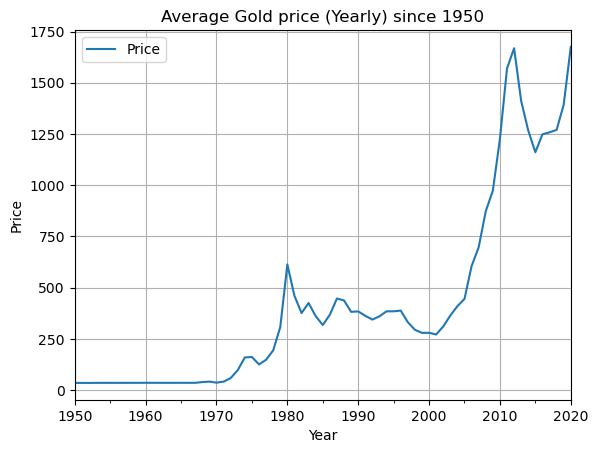

In [13]:
# Average gold price per year trend since 1950
df_yearly_sum = df.resample('A').mean()
df_yearly_sum.plot();
plt.title("Average Gold price (Yearly) since 1950")
plt.xlabel("Year")
plt.ylabel("Price")
plt.grid()

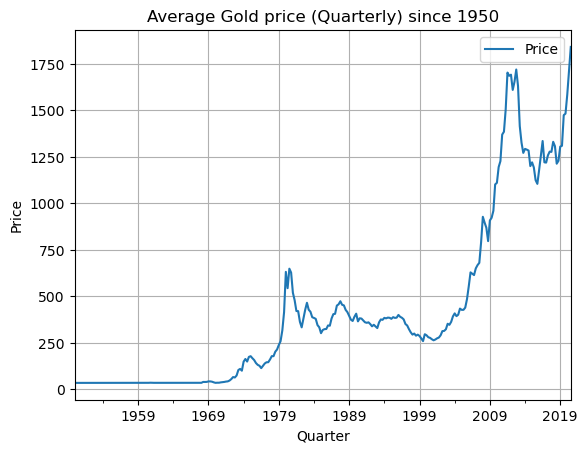

In [14]:
# Average gold price per quarter trend since 1950
df_quarterly_sum = df.resample('Q').mean()
df_quarterly_sum.plot();
plt.title("Average Gold price (Quarterly) since 1950")
plt.xlabel("Quarter")
plt.ylabel("Price")
plt.grid()

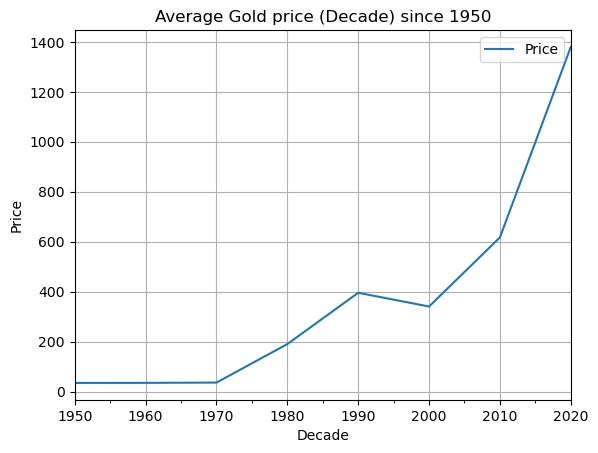

In [15]:
# Average gold price per decade trend since 1950
df_decade_sum = df.resample('10Y').mean()
df_decade_sum.plot();
plt.title("Average Gold price (Decade) since 1950")
plt.xlabel("Decade")
plt.ylabel("Price")
plt.grid()

In [16]:
# Coefficient of variation in price
df_1 = df.groupby(df.index.year).mean().rename(columns={'Price':'Mean'})
df_1 = df_1.merge(df.groupby(df.index.year).std().rename(columns={'Price':'Std'}),left_index=True,right_index=True)
df_1['CoV_pct'] = ((df_1['Std']/df_1['Mean'])*100).round(2)
df_1.head()

,Mean,Std,CoV_pct
month,,,
1950,34.729167,0.002887,0.01
1951,34.717500,0.020057,0.06
1952,34.628333,0.117538,0.34
1953,34.879167,0.056481,0.16
1954,35.020000,0.082792,0.24


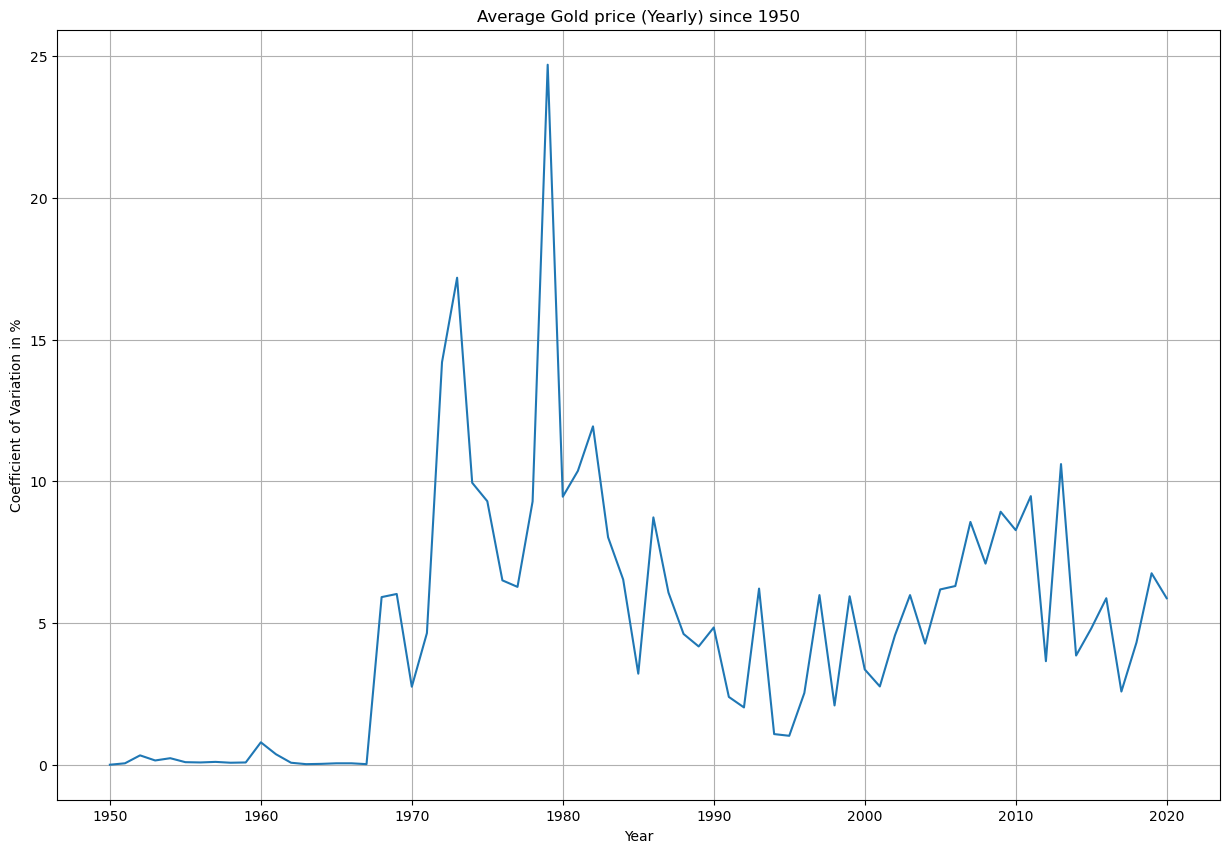

In [17]:
# Average gold price per year trend since 1950
fig, ax = plt.subplots(figsize=(15,10))
df_1['CoV_pct'].plot();
plt.title("Average Gold price (Yearly) since 1950")
plt.xlabel("Year")
plt.ylabel("Coefficient of Variation in %")
plt.grid()

In [18]:
train    =   df[df.index.year <= 2015] 
test     =   df[df.index.year > 2015]

In [19]:
print(train.shape)
print(test.shape)

(792, 1)
(55, 1)


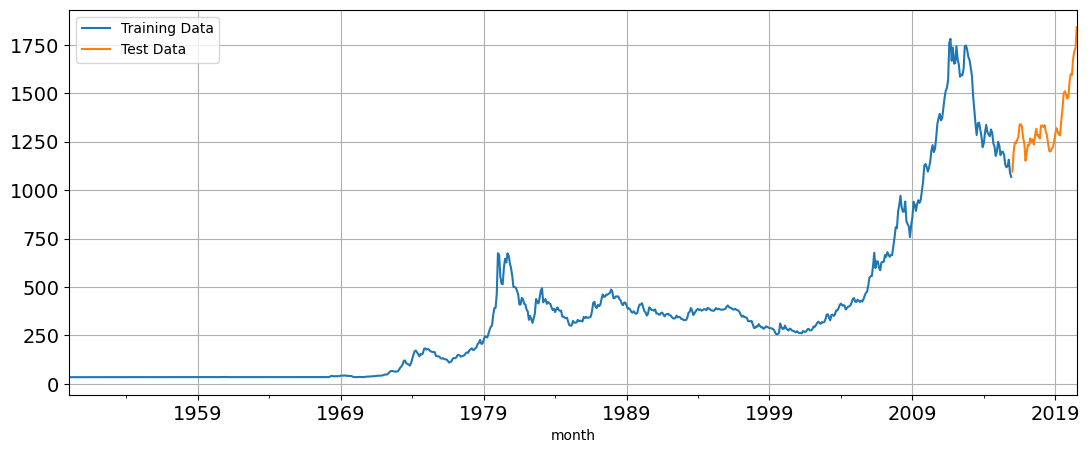

In [20]:
train['Price'].plot(figsize=(13,5), fontsize=14)
test['Price'].plot(figsize=(13,5), fontsize=14)
plt.grid()
plt.legend(['Training Data','Test Data'])
plt.show()

In [21]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+len(train)+1 for i in range(len(test))]
len(train_time), len(test_time)

(792, 55)

In [22]:
LR_train = train.copy()
LR_test = test.copy()

In [23]:
LR_train['time'] = train_time
LR_test['time'] = test_time

In [24]:
lr = LinearRegression()
lr.fit(LR_train[['time']],LR_train['Price'].values)

LinearRegression()

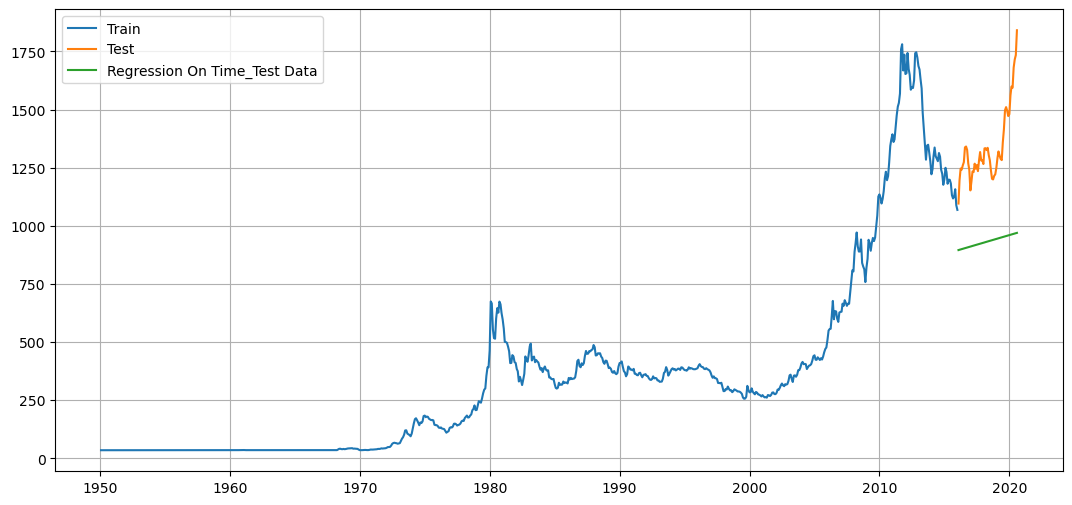

In [25]:
test_predictions_model1         = lr.predict(LR_test[['time']])
LR_test['forecast'] = test_predictions_model1

plt.figure(figsize=(13,6))
plt.plot( train['Price'], label='Train')
plt.plot(test['Price'], label='Test')
plt.plot(LR_test['forecast'], label='Regression On Time_Test Data')
plt.legend(loc='best')
plt.grid();

In [26]:
def mape(actual,pred):
    return round((np.mean(abs(actual-pred)/actual))*100,2)

In [27]:
# Get MAPE of the model

mape_model1_test = mape(test['Price'].values,test_predictions_model1)
print("For RegressionOnTime forecast on the Test Data,  MAPE is %3.3f" %(mape_model1_test),"%")

For RegressionOnTime forecast on the Test Data,  MAPE is 29.760 %


In [28]:
results = pd.DataFrame({'Test MAPE (%)': [mape_model1_test]},index=['RegressionOnTime'])
results

,Test MAPE (%)
RegressionOnTime,29.76


Model 2 - Naive prediction 

In [29]:
Naive_train = train.copy()
Naive_test = test.copy()

In [30]:
Naive_test['naive'] = np.asarray(train['Price'])[len(np.asarray(train['Price']))-1]
Naive_test['naive'].head()

month
2016-01-31    1068.317
2016-02-29    1068.317
2016-03-31    1068.317
2016-04-30    1068.317
2016-05-31    1068.317
Name: naive, dtype: float64

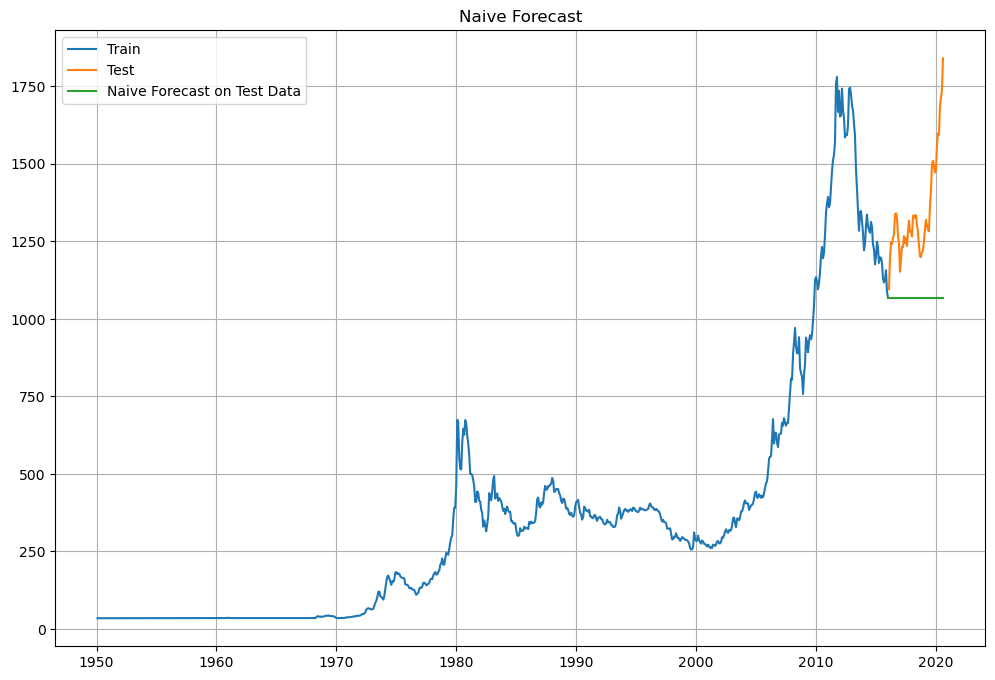

In [31]:
plt.figure(figsize=(12,8))
plt.plot(Naive_train['Price'], label='Train')
plt.plot(test['Price'], label='Test')
plt.plot(Naive_test['naive'], label='Naive Forecast on Test Data')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.grid();

In [32]:
# Get MAPE of the model

mape_model2_test = mape(test['Price'].values,Naive_test['naive'].values)
print("For Naive forecast on the Test Data,  MAPE is %3.3f" %(mape_model2_test),"%")

For Naive forecast on the Test Data,  MAPE is 19.380 %


In [33]:
resultsDf_2 = pd.DataFrame({'Test MAPE (%)': [mape_model2_test]},index=['NaiveModel'])

results = pd.concat([results, resultsDf_2])
results

,Test MAPE (%)
RegressionOnTime,29.76
NaiveModel,19.38


Model 3 - Simple Average 

In [34]:
SimpleAvg_train = train.copy()
SimpleAvg_test = test.copy()
SimpleAvg_test['mean_forecast'] = train['Price'].mean()
SimpleAvg_test.head()

,Price,mean_forecast
month,,
2016-01-31,1095.655,352.371841
2016-02-29,1194.893,352.371841
2016-03-31,1246.312,352.371841
2016-04-30,1241.452,352.371841
2016-05-31,1259.755,352.371841


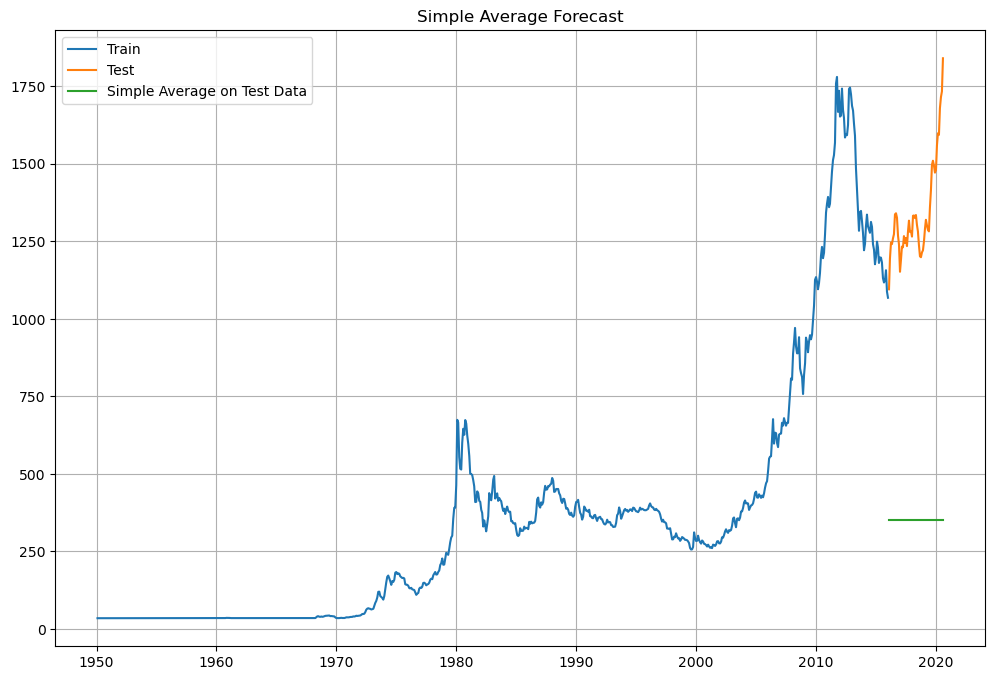

In [35]:
plt.figure(figsize=(12,8))
plt.plot(SimpleAvg_train['Price'], label='Train')
plt.plot(SimpleAvg_test['Price'], label='Test')
plt.plot(SimpleAvg_test['mean_forecast'], label='Simple Average on Test Data')
plt.legend(loc='best')
plt.title("Simple Average Forecast")
plt.grid();

In [36]:
## Test Data - MAPE

mape_model3_test = mape(test['Price'].values,SimpleAvg_test['mean_forecast'].values)
print("For Simple Average forecast on the Test Data,  MAPE is %3.3f" %(mape_model3_test),"%")

For Simple Average forecast on the Test Data,  MAPE is 73.410 %


In [37]:
resultsDf_3 = pd.DataFrame({'Test MAPE (%)': [mape_model3_test]},index=['SimpleAverageModel'])

results = pd.concat([results, resultsDf_3])
results

,Test MAPE (%)
RegressionOnTime,29.76
NaiveModel,19.38
SimpleAverageModel,73.41


**Model 4 - Moving Average **

In [38]:
Mvg_Avg = df.copy()
Mvg_Avg['Trailing_2'] = Mvg_Avg['Price'].rolling(2).mean()
Mvg_Avg['Trailing_3'] = Mvg_Avg['Price'].rolling(3).mean()
Mvg_Avg['Trailing_5'] = Mvg_Avg['Price'].rolling(5).mean()
Mvg_Avg['Trailing_7'] = Mvg_Avg['Price'].rolling(7).mean()
Mvg_Avg.head()

,Price,Trailing_2,Trailing_3,Trailing_5,Trailing_7
month,,,,,
1950-01-31,34.73,NaN,NaN,NaN,NaN
1950-02-28,34.73,34.73,NaN,NaN,NaN
1950-03-31,34.73,34.73,34.73,NaN,NaN
1950-04-30,34.73,34.73,34.73,NaN,NaN
1950-05-31,34.73,34.73,34.73,34.73,NaN


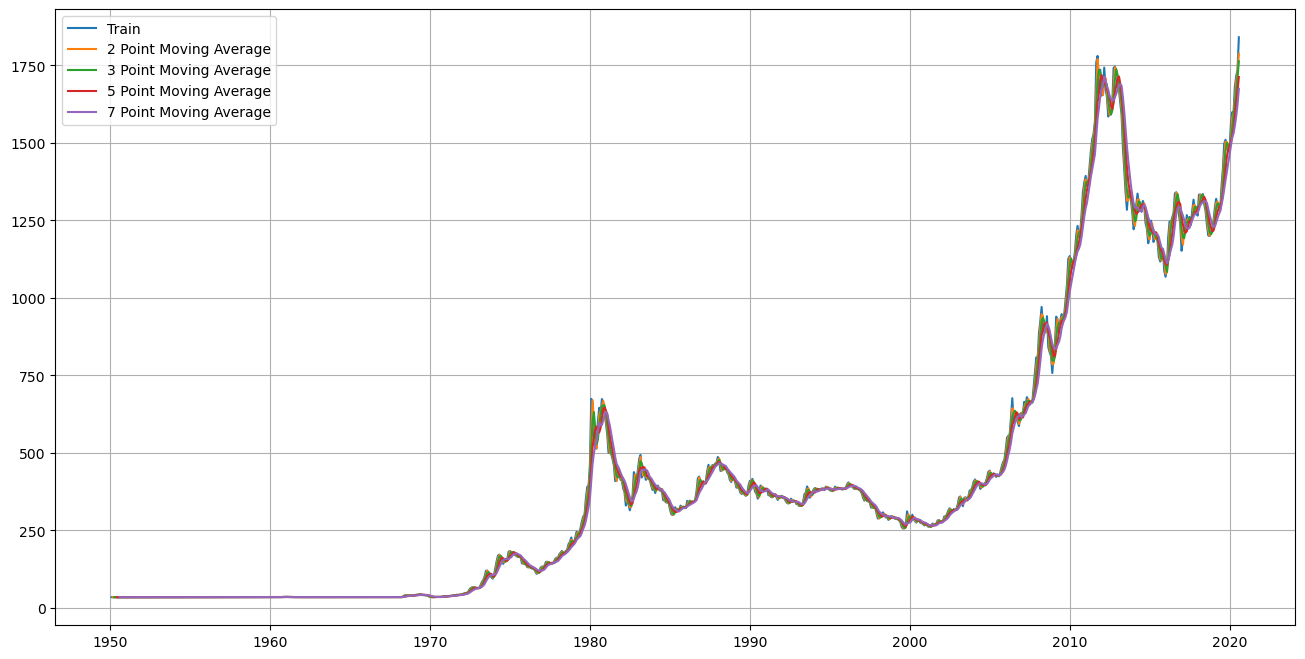

In [39]:
## Plotting on the whole data

plt.figure(figsize=(16,8))
plt.plot(Mvg_Avg['Price'], label='Train')
plt.plot(Mvg_Avg['Trailing_2'],label='2 Point Moving Average')
plt.plot(Mvg_Avg['Trailing_3'],label='3 Point Moving Average')
plt.plot(Mvg_Avg['Trailing_5'],label = '5 Point Moving Average')
plt.plot(Mvg_Avg['Trailing_7'],label = '7 Point Moving Average')

plt.legend(loc = 'best')
plt.grid();

In [40]:
#Creating train and test set 
trailing_Mvg_Avg_train=Mvg_Avg[Mvg_Avg.index.year <= 2015] 
trailing_Mvg_Avg_test=Mvg_Avg[Mvg_Avg.index.year > 2015]

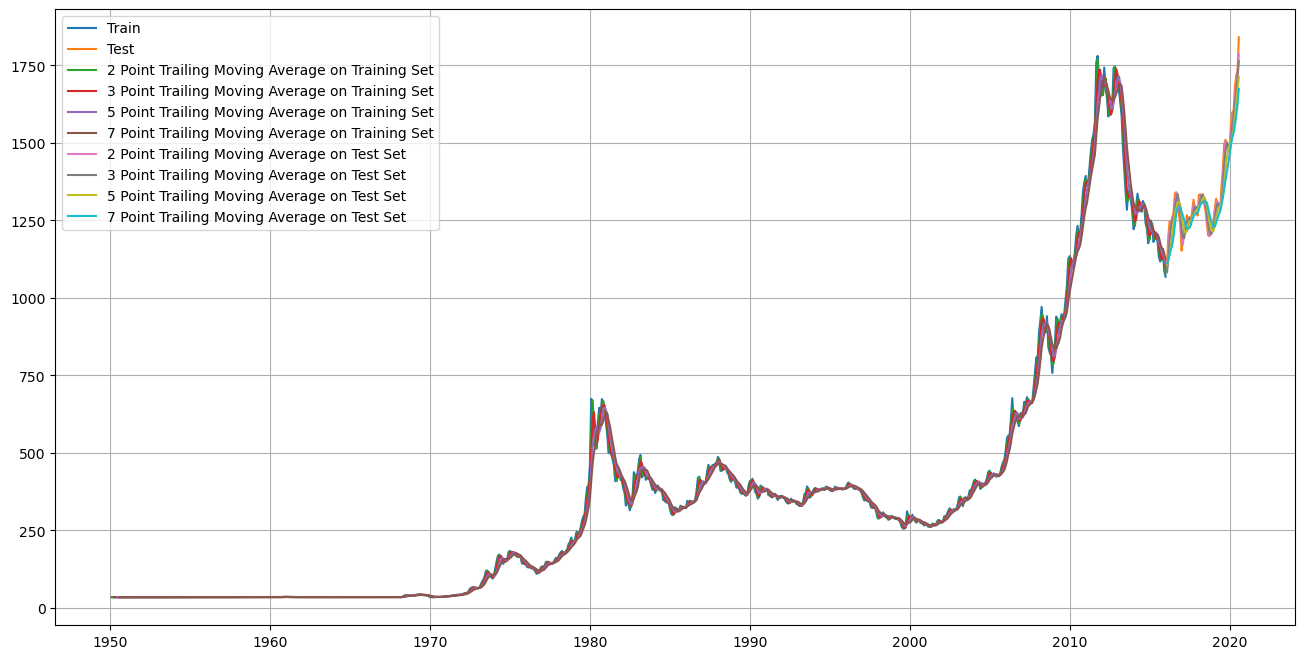

In [41]:
## Plotting on both the Training and Test data

plt.figure(figsize=(16,8))
plt.plot(trailing_Mvg_Avg_train['Price'], label='Train')
plt.plot(trailing_Mvg_Avg_test['Price'], label='Test')

plt.plot(trailing_Mvg_Avg_train['Trailing_2'],label='2 Point Trailing Moving Average on Training Set')
plt.plot(trailing_Mvg_Avg_train['Trailing_3'],label='3 Point Trailing Moving Average on Training Set')
plt.plot(trailing_Mvg_Avg_train['Trailing_5'],label = '5 Point Trailing Moving Average on Training Set')
plt.plot(trailing_Mvg_Avg_train['Trailing_7'],label = '7 Point Trailing Moving Average on Training Set')

plt.plot(trailing_Mvg_Avg_test['Trailing_2'], label='2 Point Trailing Moving Average on Test Set')
plt.plot(trailing_Mvg_Avg_test['Trailing_3'], label='3 Point Trailing Moving Average on Test Set')
plt.plot(trailing_Mvg_Avg_test['Trailing_5'],label = '5 Point Trailing Moving Average on Test Set')
plt.plot(trailing_Mvg_Avg_test['Trailing_7'],label = '7 Point Trailing Moving Average on Test Set')
plt.legend(loc = 'best')
plt.grid();

In [42]:
## Test Data - MAPE --> 2 point Trailing MA

mape_model4_test_2 = mape(test['Price'].values,trailing_Mvg_Avg_test['Trailing_2'].values)
print("For 2 point Moving Average Model forecast on the Training Data,  MAPE is %3.3f" %(mape_model4_test_2),"%")

## Test Data - MAPE  --> 3 point Trailing MA

mape_model4_test_3 = mape(test['Price'].values,trailing_Mvg_Avg_test['Trailing_3'].values)
print("For 3 point Moving Average Model forecast on the Training Data,  MAPE is %3.3f" %(mape_model4_test_3),"%")

## Test Data - MAPE --> 5 point Trailing MA

mape_model4_test_5 = mape(test['Price'].values,trailing_Mvg_Avg_test['Trailing_5'].values)
print("For 5 point Moving Average Model forecast on the Training Data,  MAPE is %3.3f" %(mape_model4_test_5),"%")

## Test Data - MAPE  --> 7 point Trailing MA

mape_model4_test_7 = mape(test['Price'].values,trailing_Mvg_Avg_test['Trailing_7'].values)
print("For 7 point Moving Average Model forecast on the Training Data,  MAPE is %3.3f " %(mape_model4_test_7),"%")

For 2 point Moving Average Model forecast on the Training Data,  MAPE is 1.230 %
For 3 point Moving Average Model forecast on the Training Data,  MAPE is 2.050 %
For 5 point Moving Average Model forecast on the Training Data,  MAPE is 3.330 %
For 7 point Moving Average Model forecast on the Training Data,  MAPE is 4.180  %


In [43]:
resultsDf_4 = pd.DataFrame({'Test MAPE (%)': [mape_model4_test_2,mape_model4_test_3
                                          ,mape_model4_test_5,mape_model4_test_7]}
                           ,index=['2pointTrailingMovingAverage','3pointTrailingMovingAverage'
                                   ,'5pointTrailingMovingAverage','7pointTrailingMovingAverage'])

results = pd.concat([results, resultsDf_4])
results

,Test MAPE (%)
RegressionOnTime,29.76
NaiveModel,19.38
SimpleAverageModel,73.41
2pointTrailingMovingAverage,1.23
3pointTrailingMovingAverage,2.05
5pointTrailingMovingAverage,3.33
7pointTrailingMovingAverage,4.18


In [44]:
#Model 5 - Simple Exponential Smoothing 

**Model 5 - Simple Exponential Smoothing **

In [45]:
SES_train = train.copy()
SES_test = test.copy()

In [46]:
model_SES = SimpleExpSmoothing(SES_train['Price'])
model_SES_autofit = model_SES.fit(optimized=True)

In [47]:
model_SES_autofit.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 34.73,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [48]:
SES_test['predict'] = model_SES_autofit.forecast(steps=len(test))
SES_test.head()

,Price,predict
month,,
2016-01-31,1095.655,1068.419069
2016-02-29,1194.893,1068.419069
2016-03-31,1246.312,1068.419069
2016-04-30,1241.452,1068.419069
2016-05-31,1259.755,1068.419069


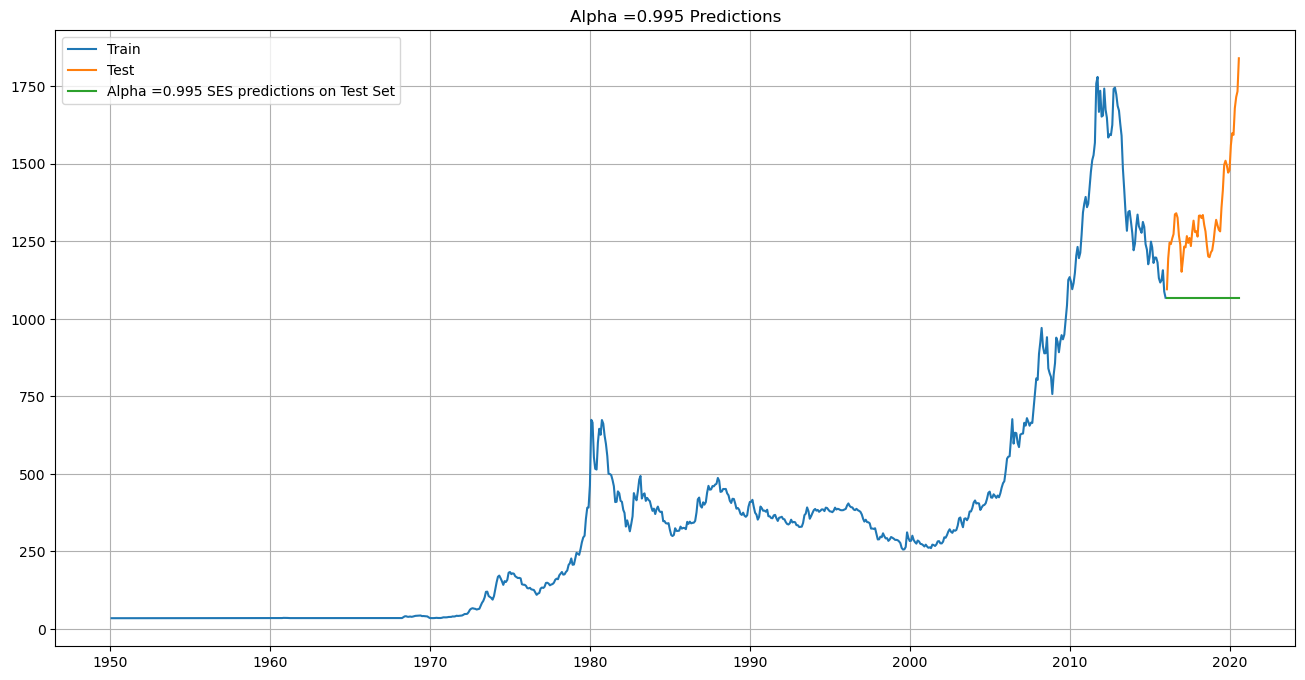

In [49]:
## Plotting on both the Training and Test data

plt.figure(figsize=(16,8))
plt.plot(SES_train['Price'], label='Train')
plt.plot(SES_test['Price'], label='Test')

plt.plot(SES_test['predict'], label='Alpha =0.995 SES predictions on Test Set')

plt.legend(loc='best')
plt.grid()
plt.title('Alpha =0.995 Predictions');

In [50]:
## Test Data

mape_model5_test_1 = mape(SES_test['Price'].values,SES_test['predict'].values)
print("For Alpha =0.995 SES Model forecast on the Test Data, MAPE is %3.3f" %(mape_model5_test_1),"%")

For Alpha =0.995 SES Model forecast on the Test Data, MAPE is 19.380 %


In [51]:
resultsDf_5 = pd.DataFrame({'Test MAPE (%)': [mape_model5_test_1]},index=['Alpha=0.995,SimpleExponentialSmoothing'])

results = pd.concat([results, resultsDf_5])
results

,Test MAPE (%)
RegressionOnTime,29.76
NaiveModel,19.38
SimpleAverageModel,73.41
2pointTrailingMovingAverage,1.23
3pointTrailingMovingAverage,2.05
5pointTrailingMovingAverage,3.33
7pointTrailingMovingAverage,4.18
"Alpha=0.995,SimpleExponentialSmoothing",19.38


In [52]:
resultsDf_6 = pd.DataFrame({'Alpha Values':[],'Train MAPE':[],'Test MAPE': []})

for i in np.arange(0.3,1,0.1):
    model_SES_alpha_i = model_SES.fit(smoothing_level=i,optimized=False,use_brute=True)
    SES_train['predict',i] = model_SES_alpha_i.fittedvalues
    SES_test['predict',i] = model_SES_alpha_i.forecast(steps=55)
    
    mape_model5_train_i = mape(SES_train['Price'].values,SES_train['predict',i].values)
    
    mape_model5_test_i = mape(SES_test['Price'].values,SES_test['predict',i].values)
    
    resultsDf_6 = resultsDf_6.append({'Alpha Values':i,'Train MAPE':mape_model5_train_i 
                                      ,'Test MAPE':mape_model5_test_i}, ignore_index=True)

In [53]:
resultsDf_6.sort_values(by=['Test MAPE'],ascending=True)

,Alpha Values,Train MAPE,Test MAPE
0,0.3,4.02,16.03
1,0.4,3.45,16.92
2,0.5,3.11,17.57
3,0.6,2.87,18.09
4,0.7,2.71,18.53
5,0.8,2.58,18.89
6,0.9,2.47,19.18


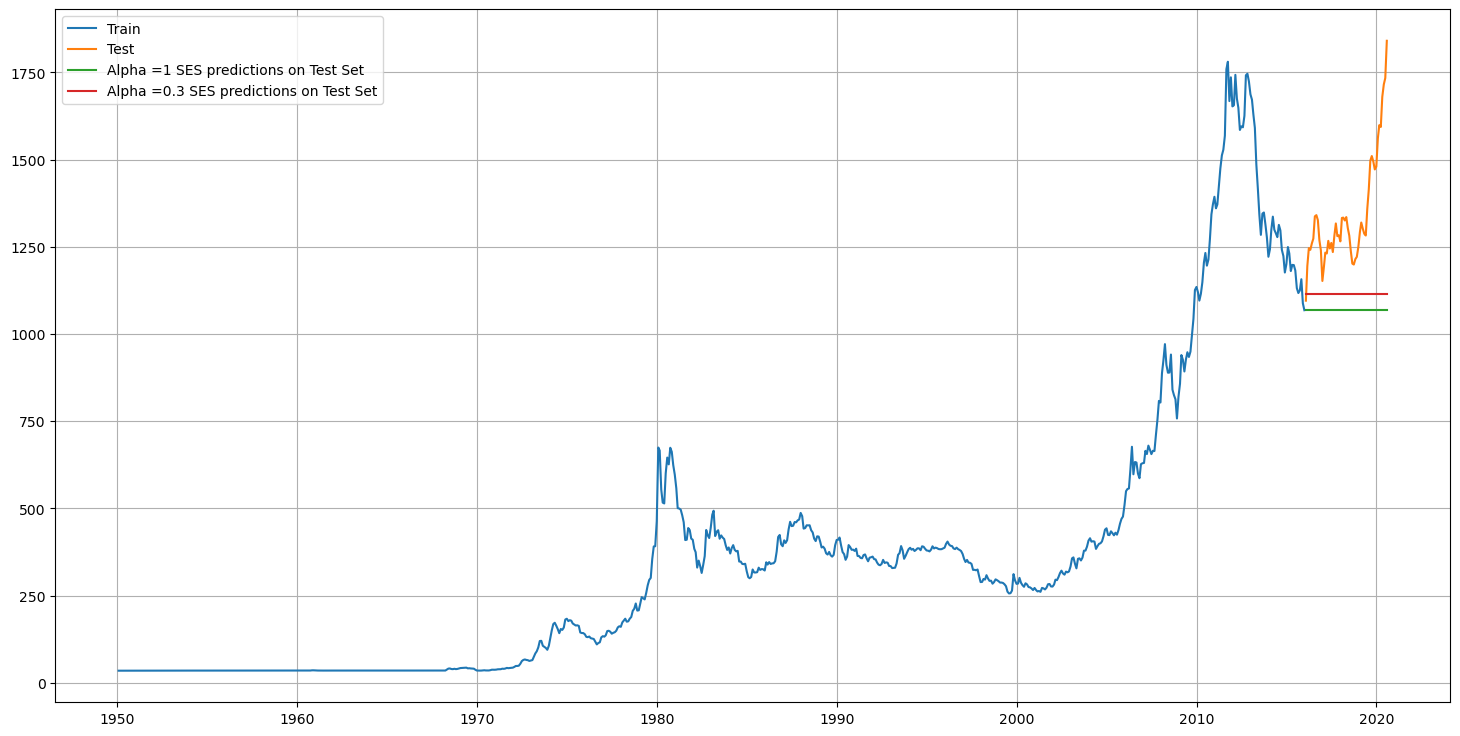

In [54]:
## Plotting on both the Training and Test data

plt.figure(figsize=(18,9))
plt.plot(SES_train['Price'], label='Train')
plt.plot(SES_test['Price'], label='Test')

plt.plot(SES_test['predict'], label='Alpha =1 SES predictions on Test Set')

plt.plot(SES_test['predict', 0.3], label='Alpha =0.3 SES predictions on Test Set')



plt.legend(loc='best')
plt.grid();

In [55]:
resultsDf_6_1 = pd.DataFrame({'Test MAPE (%)': [resultsDf_6.sort_values(by=['Test MAPE'],ascending=True).values[0][2]]}
                           ,index=['Alpha=0.3,SimpleExponentialSmoothing'])

results = pd.concat([results, resultsDf_6_1])
results

,Test MAPE (%)
RegressionOnTime,29.76
NaiveModel,19.38
SimpleAverageModel,73.41
2pointTrailingMovingAverage,1.23
3pointTrailingMovingAverage,2.05
5pointTrailingMovingAverage,3.33
7pointTrailingMovingAverage,4.18
"Alpha=0.995,SimpleExponentialSmoothing",19.38
"Alpha=0.3,SimpleExponentialSmoothing",16.03


In [56]:
#Model 6 - Double Exponential smoothing

In [57]:
DES_train = train.copy()
DES_test = test.copy()

In [58]:
model_DES = Holt(DES_train['Price'])

In [59]:
resultsDf_7 = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Train MAPE':[],'Test MAPE': []})

for i in np.arange(0.3,1.1,0.1):
    for j in np.arange(0.3,1.1,0.1):
        model_DES_alpha_i_j = model_DES.fit(smoothing_level=i,smoothing_trend=j,optimized=False,use_brute=True)
        DES_train['predict',i,j] = model_DES_alpha_i_j.fittedvalues
        DES_test['predict',i,j] = model_DES_alpha_i_j.forecast(steps=55)
        
        mape_model6_train = mape(DES_train['Price'].values,DES_train['predict',i,j].values)
        
        mape_model6_test = mape(DES_test['Price'].values,DES_test['predict',i,j].values)
        
        resultsDf_7 = resultsDf_7.append({'Alpha Values':i,'Beta Values':j,'Train MAPE':mape_model6_train
                                          ,'Test MAPE':mape_model6_test}, ignore_index=True)

In [60]:
resultsDf_7.sort_values(by=['Test MAPE']).head()

,Alpha Values,Beta Values,Train MAPE,Test MAPE
0,0.3,0.3,3.60,47.89
7,0.3,1.0,3.93,48.23
1,0.3,0.4,3.61,48.59
8,0.4,0.3,3.23,49.22
16,0.5,0.3,2.99,50.92


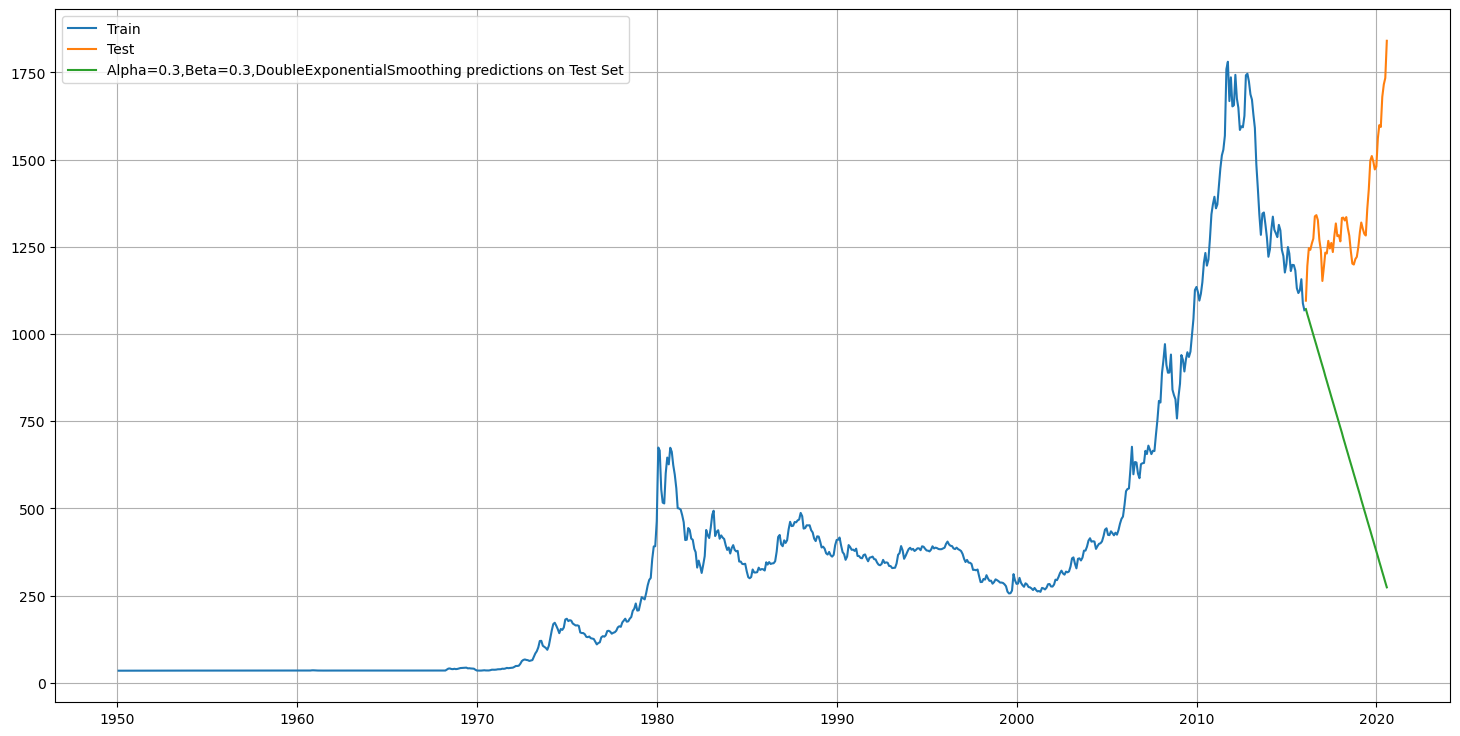

In [61]:
## Plotting on both the Training and Test data

plt.figure(figsize=(18,9))
plt.plot(DES_train['Price'], label='Train')
plt.plot(DES_test['Price'], label='Test')

plt.plot(DES_test['predict', 0.3, 0.3], label='Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid();

In [62]:
resultsDf_7_1 = pd.DataFrame({'Test MAPE (%)': [resultsDf_7.sort_values(by=['Test MAPE']).values[0][3]]}
                           ,index=['Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing'])

results = pd.concat([results, resultsDf_7_1])
results

,Test MAPE (%)
RegressionOnTime,29.76
NaiveModel,19.38
SimpleAverageModel,73.41
2pointTrailingMovingAverage,1.23
3pointTrailingMovingAverage,2.05
5pointTrailingMovingAverage,3.33
7pointTrailingMovingAverage,4.18
"Alpha=0.995,SimpleExponentialSmoothing",19.38
"Alpha=0.3,SimpleExponentialSmoothing",16.03
"Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing",47.89


In [63]:
#Model 7 - Triple Exponential Smoothing

In [64]:
TES_train = train.copy()
TES_test = test.copy()

In [65]:
model_TES = ExponentialSmoothing(TES_train['Price'],trend='additive',seasonal='additive',freq='M')
model_TES_autofit = model_TES.fit()

In [66]:
model_TES_autofit.params

{'smoothing_level': 0.9882650049836023,
 'smoothing_trend': 0.04330111199752529,
 'smoothing_seasonal': 0.00027777194103934075,
 'damping_trend': nan,
 'initial_level': 34.696616892614706,
 'initial_trend': -0.0006256708181916408,
 'initial_seasons': array([ 2.5039874 ,  4.36128596,  0.63955948, -0.99743837, -0.82265517,
        -2.40392822, -3.45115069, -1.70782781,  2.8071071 ,  1.98524897,
        -0.90351499, -2.04333077]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [67]:
## Prediction on the test data

TES_test['auto_predict'] = model_TES_autofit.forecast(steps=len(test))
TES_test.head()

,Price,auto_predict
month,,
2016-01-31,1095.655,1064.096947
2016-02-29,1194.893,1057.063498
2016-03-31,1246.312,1044.449173
2016-04-30,1241.452,1033.929375
2016-05-31,1259.755,1025.224197


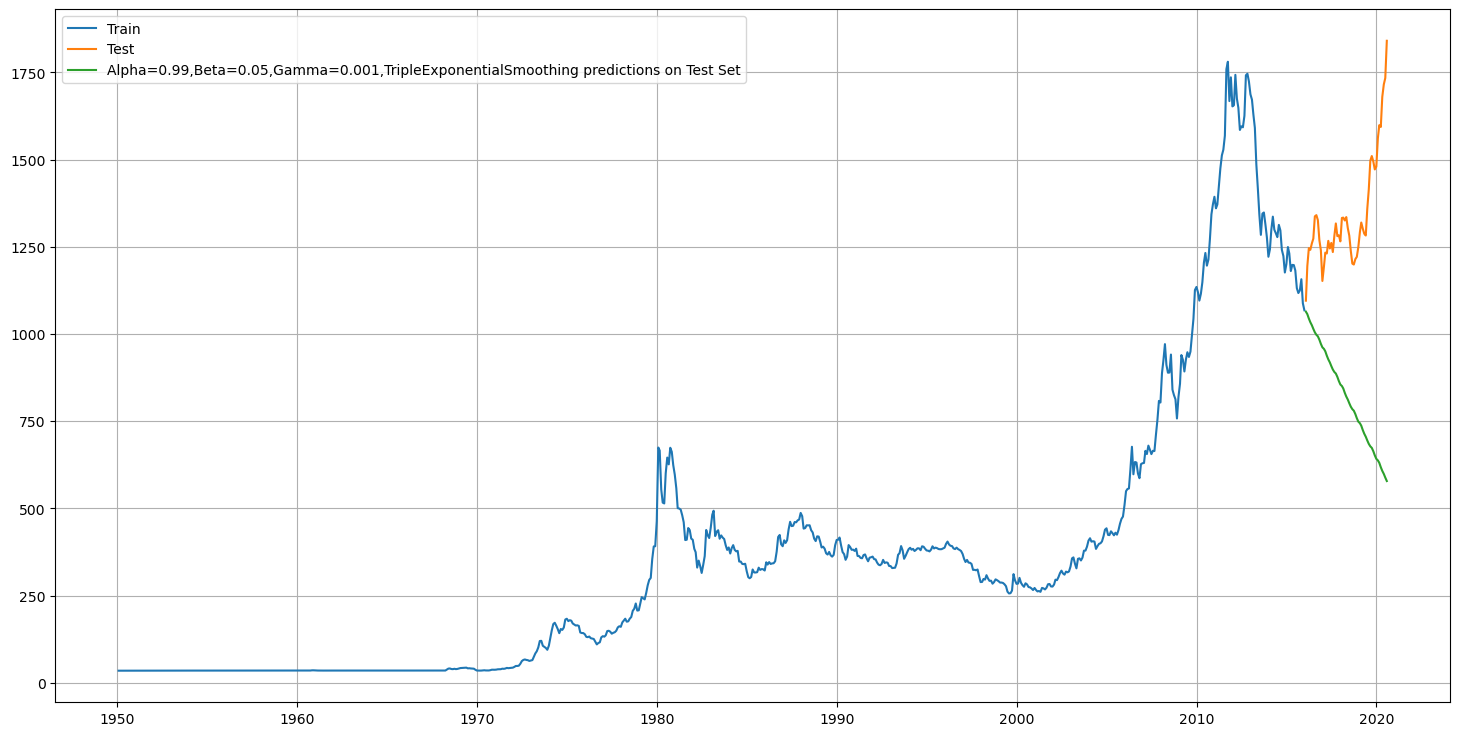

In [68]:
## Plotting on both the Training and Test using autofit

plt.figure(figsize=(18,9))
plt.plot(TES_train['Price'], label='Train')
plt.plot(TES_test['Price'], label='Test')

plt.plot(TES_test['auto_predict'], label='Alpha=0.99,Beta=0.05,Gamma=0.001,TripleExponentialSmoothing predictions on Test Set')


plt.legend(loc='best')
plt.grid();

In [69]:
## Test Data

mape_model6_test_1 = mape(TES_test['Price'].values,TES_test['auto_predict'].values)
print("For A=0.99,B=0.05,G=0.001, Triple ES Model forecast on the Test Data,  MAPE is %3.3f" %(mape_model6_test_1),"%")

For A=0.99,B=0.05,G=0.001, Triple ES Model forecast on the Test Data,  MAPE is 37.170 %


In [70]:
resultsDf_8_1 = pd.DataFrame({'Test MAPE (%)': [mape_model6_test_1]}
                           ,index=['Alpha=0.99,Beta=0.05,Gamma=0.001,TripleExponentialSmoothing'])

results = pd.concat([results, resultsDf_8_1])
results

,Test MAPE (%)
RegressionOnTime,29.76
NaiveModel,19.38
SimpleAverageModel,73.41
2pointTrailingMovingAverage,1.23
3pointTrailingMovingAverage,2.05
5pointTrailingMovingAverage,3.33
7pointTrailingMovingAverage,4.18
"Alpha=0.995,SimpleExponentialSmoothing",19.38
"Alpha=0.3,SimpleExponentialSmoothing",16.03
"Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing",47.89


In [71]:
## First we will define an empty dataframe to store our values from the loop

resultsDf_8_2 = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Gamma Values':[],'Train MAPE':[],'Test MAPE': []})
resultsDf_8_2

,Alpha Values,Beta Values,Gamma Values,Train MAPE,Test MAPE


In [72]:
for i in np.arange(0.3,1.1,0.1):
    for j in np.arange(0.3,1.1,0.1):
        for k in np.arange(0.3,1.1,0.1):
            model_TES_alpha_i_j_k = model_TES.fit(smoothing_level=i,smoothing_trend=j,smoothing_seasonal=k,optimized=False,use_brute=True)
            TES_train['predict',i,j,k] = model_TES_alpha_i_j_k.fittedvalues
            TES_test['predict',i,j,k] = model_TES_alpha_i_j_k.forecast(steps=55)
        
            mape_model8_train = mape(TES_train['Price'].values,TES_train['predict',i,j,k].values)
            
            mape_model8_test = mape(TES_test['Price'].values,TES_test['predict',i,j,k].values)
            
            resultsDf_8_2 = resultsDf_8_2.append({'Alpha Values':i,'Beta Values':j,'Gamma Values':k,
                                                  'Train MAPE':mape_model8_train,'Test MAPE':mape_model8_test}
                                                 , ignore_index=True)

In [73]:
resultsDf_8_2.sort_values(by=['Test MAPE']).head()

,Alpha Values,Beta Values,Gamma Values,Train MAPE,Test MAPE
67,0.4,0.3,0.6,11.53,5.99
320,0.8,0.3,0.3,3.81,6.94
24,0.3,0.6,0.3,11.68,9.56
130,0.5,0.3,0.5,8.93,13.07
73,0.4,0.4,0.4,8.75,14.99


In [74]:
model_TES_alpha_best = model_TES.fit(smoothing_level=0.4,
                                      smoothing_trend=0.3,
                                      smoothing_seasonal=0.6,
                                      optimized=False,
                                      use_brute=True)
TES_train['predict',0.4,0.3,0.6] = model_TES_alpha_best.fittedvalues
TES_test['predict',0.4,0.3,0.6] = model_TES_alpha_best.forecast(steps=55)

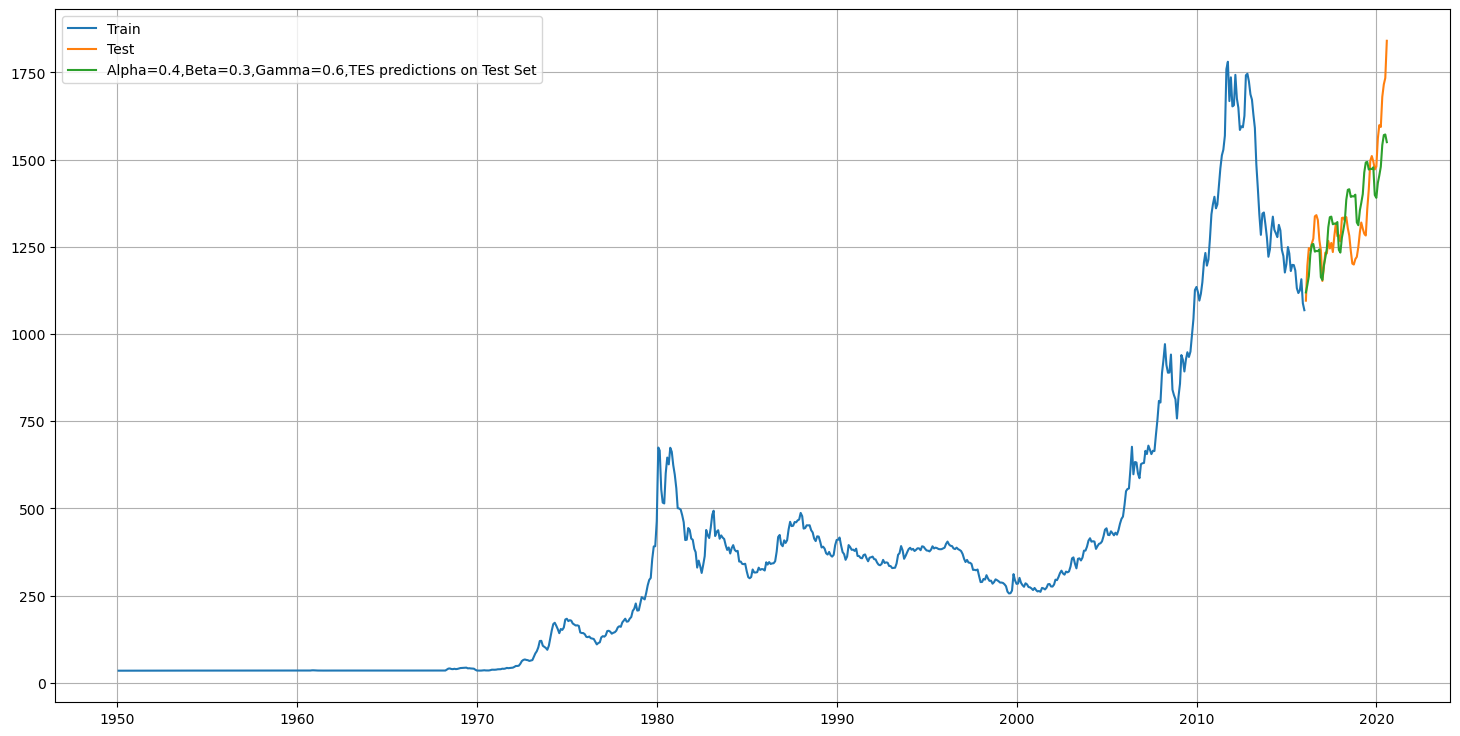

In [75]:
## Plotting on both the Training and Test data using brute force alpha, beta and gamma determination

plt.figure(figsize=(18,9))
plt.plot(TES_train['Price'], label='Train')
plt.plot(TES_test['Price'], label='Test')

#The value of alpha and beta is taken like that by python
plt.plot(TES_test['predict', 0.4, 0.3, 0.6], label='Alpha=0.4,Beta=0.3,Gamma=0.6,TES predictions on Test Set')


plt.legend(loc='best')
plt.grid();

In [76]:
## Test Data

mape_model7_test = mape(TES_test['Price'].values,TES_test['predict',0.4,0.3,0.6].values)
print("For A=0.4,B=0.3,G=0.6, Triple ES Model forecast on the Test Data,  MAPE is %3.3f" %(mape_model7_test),"%")

For A=0.4,B=0.3,G=0.6, Triple ES Model forecast on the Test Data,  MAPE is 5.990 %


In [77]:
resultsDf_9_1 = pd.DataFrame({'Test MAPE (%)': [mape_model7_test]}
                           ,index=['Alpha=0.4,Beta=0.3,Gamma=0.6,TripleExponentialSmoothing'])

results = pd.concat([results, resultsDf_9_1])
results

,Test MAPE (%)
RegressionOnTime,29.76
NaiveModel,19.38
SimpleAverageModel,73.41
2pointTrailingMovingAverage,1.23
3pointTrailingMovingAverage,2.05
5pointTrailingMovingAverage,3.33
7pointTrailingMovingAverage,4.18
"Alpha=0.995,SimpleExponentialSmoothing",19.38
"Alpha=0.3,SimpleExponentialSmoothing",16.03
"Alpha=0.3,Beta=0.3,DoubleExponentialSmoothing",47.89


In [78]:
##Final Model 

In [79]:
final_model =  ExponentialSmoothing(df,
                                  trend='additive',
                                  seasonal='additive').fit(smoothing_level=0.4,
                                                           smoothing_trend=0.3,
                                                           smoothing_seasonal=0.6)

In [80]:
MAPE_final_model = mape(df['Price'].values,final_model.fittedvalues)

print('MAPE:',MAPE_final_model)

MAPE: 17.24


In [81]:
# Getting the predictions for the same number of times stamps that are present in the test data
prediction = final_model.forecast(steps=len(test))

In [82]:
# Compute 95% confidence interval for predicted values
pred_df = pd.DataFrame({'lower_CI':prediction - 1.96*np.std(final_model.resid,ddof=1),
                        'prediction':prediction,
                        'upper_CI': prediction + 1.96*np.std(final_model.resid,ddof=1)})
pred_df.head()

,lower_CI,prediction,upper_CI
2020-08-31,1684.720065,1792.871037,1901.022009
2020-09-30,1615.306077,1723.457050,1831.608022
2020-10-31,1538.567922,1646.718895,1754.869867
2020-11-30,1476.758600,1584.909572,1693.060545
2020-12-31,1459.327290,1567.478262,1675.629235


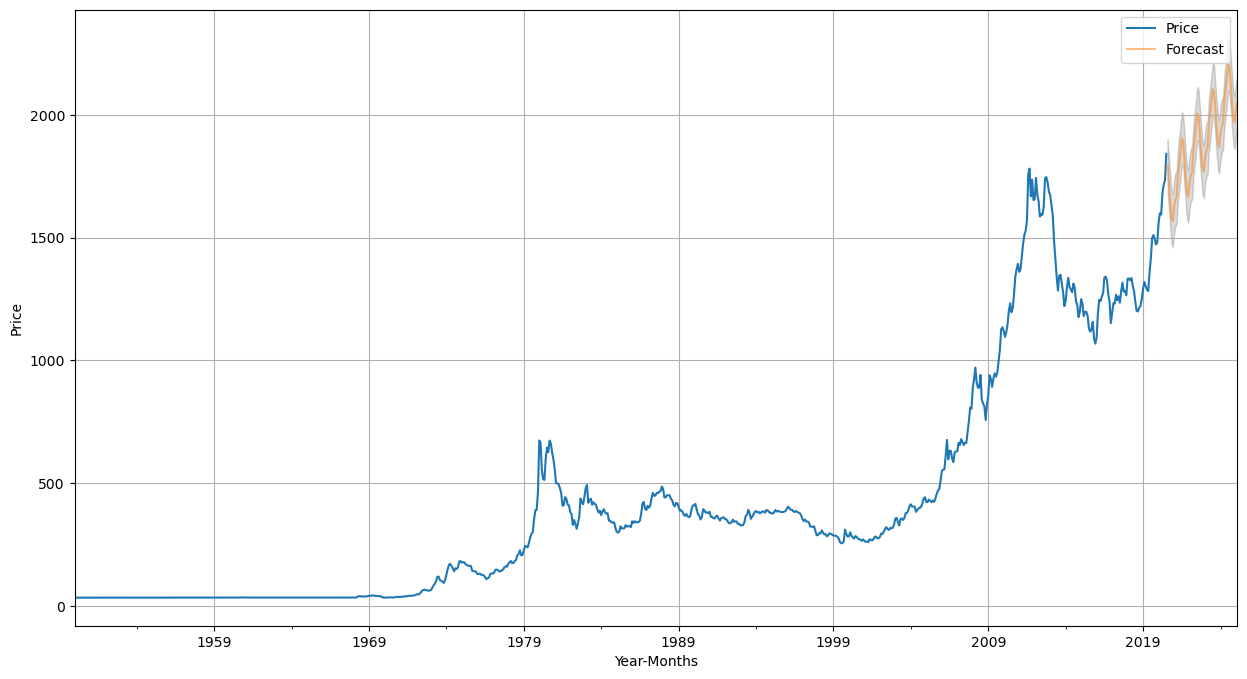

In [83]:
# plot the forecast along with the confidence band

axis = df.plot(label='Actual', figsize=(15,8))
pred_df['prediction'].plot(ax=axis, label='Forecast', alpha=0.5)
axis.fill_between(pred_df.index, pred_df['lower_CI'], pred_df['upper_CI'], color='k', alpha=.15)
axis.set_xlabel('Year-Months')
axis.set_ylabel('Price')
plt.legend(loc='best')
plt.grid()
plt.show()

In [84]:
# END OF NOTEBOOK